In [1]:
# Import packages
from __future__ import print_function

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd

import os
import re
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)


from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier

# Utility Functions

def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)

def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['acc'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_confusion_matrix(model, X, y):
    y_pred = model.predict_classes(X, verbose=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)
    plt.title('Confusion matrix of the classifier')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Loss")
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")

    plt.tight_layout()
    
def make_sine_wave():
    c = 3
    num = 2400
    step = num/(c*4)
    np.random.seed(0)
    x0 = np.linspace(-c*np.pi, c*np.pi, num)
    x1 = np.sin(x0)
    noise = np.random.normal(0, 0.1, num) + 0.1
    noise = np.sign(x1) * np.abs(noise)
    x1  = x1 + noise
    x0 = x0 + (np.asarray(range(num)) / step) * 0.3
    X = np.column_stack((x0, x1))
    y = np.asarray([int((i/step)%2==1) for i in range(len(x0))])
    return X, y

def make_multiclass(N=500, D=2, K=3):
    """
    N: number of points per class
    D: dimensionality
    K: number of classes
    """
    np.random.seed(0)
    X = np.zeros((N*K, D))
    y = np.zeros(N*K)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        # radius
        r = np.linspace(0.0,1,N)
        # theta
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    return X, y

 

Using TensorFlow backend.


In [2]:
#Load the dataset
df_creditcarddata = pd.read_csv("UCI_Credit_Card.csv")
df_creditcarddata.head() # see if it is loaded properly


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,"20,000.00",2,2,1,24,2,2,-1,-1,-2,-2,"3,913.00","3,102.00",689.00,0.00,0.00,0.00,0.00,689.00,0.00,0.00,0.00,0.00,1
1,2,"120,000.00",2,2,2,26,-1,2,0,0,0,2,"2,682.00","1,725.00","2,682.00","3,272.00","3,455.00","3,261.00",0.00,"1,000.00","1,000.00","1,000.00",0.00,"2,000.00",1
2,3,"90,000.00",2,2,2,34,0,0,0,0,0,0,"29,239.00","14,027.00","13,559.00","14,331.00","14,948.00","15,549.00","1,518.00","1,500.00","1,000.00","1,000.00","1,000.00","5,000.00",0
3,4,"50,000.00",2,2,1,37,0,0,0,0,0,0,"46,990.00","48,233.00","49,291.00","28,314.00","28,959.00","29,547.00","2,000.00","2,019.00","1,200.00","1,100.00","1,069.00","1,000.00",0
4,5,"50,000.00",1,2,1,57,-1,0,-1,0,0,0,"8,617.00","5,670.00","35,835.00","20,940.00","19,146.00","19,131.00","2,000.00","36,681.00","10,000.00","9,000.00",689.00,679.00,0


In [3]:

# Data prep

# Assigning labels to features to make interpretation easier

GenderMap = {2:'female', 1:'male'}
MarriageMap = {1:'married', 2:'single', 3:'other', 0: 'other'}
EducationMap = {1:'graduate school', 2:'university', 3:'high school', 4:'others', 5:'unknown', 6:'unknown', 0:'unknown'}


df_creditcarddata['SEX'] = df_creditcarddata.SEX.map(GenderMap)
df_creditcarddata['MARRIAGE'] = df_creditcarddata.MARRIAGE.map(MarriageMap) 
df_creditcarddata['EDUCATION'] = df_creditcarddata.EDUCATION.map(EducationMap)
df_creditcarddata['PAY_0'] = df_creditcarddata['PAY_0'].astype(str) 
df_creditcarddata['PAY_2'] = df_creditcarddata['PAY_2'].astype(str) 
df_creditcarddata['PAY_3'] = df_creditcarddata['PAY_3'].astype(str) 
df_creditcarddata['PAY_4'] = df_creditcarddata['PAY_4'].astype(str) 
df_creditcarddata['PAY_5'] = df_creditcarddata['PAY_5'].astype(str) 
df_creditcarddata['PAY_6'] = df_creditcarddata['PAY_6'].astype(str)

# Split the target variables
predictor= df_creditcarddata.iloc[:, df_creditcarddata.columns != 'default.payment.next.month']
target= df_creditcarddata.iloc[:, df_creditcarddata.columns == 'default.payment.next.month']

# save all categorical columns in list
categorical_columns = [col for col in predictor.columns.values if predictor[col].dtype == 'object']

# dataframe with categorical features
df_categorical = predictor[categorical_columns]

# dataframe with numerical features
df_numeric = predictor.drop(categorical_columns, axis=1)

# Using pandas.get_dummies function to Convert categorical variable into dummy/indicator variables
dummy_code_cat_vars  = pd.get_dummies(df_categorical,drop_first=True)

# using concat function we merging two dataframe for further analysis
df_predictor = pd.concat([df_numeric, dummy_code_cat_vars], axis=1)



In [4]:

#Let us now split the dataset into train & test

from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(df_predictor, target, test_size = 0.30, random_state=0,stratify=target)
print("x_train ",X_train.shape)
print("x_test ",X_test.shape)
print("y_train ",y_train.shape)
print("y_test ",y_test.shape)



# Standarize features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

X_train_scaled.columns = X_train.columns.values
X_test_scaled.columns = X_test.columns.values
X_train_scaled.index = X_train.index.values
X_test_scaled.index = X_test.index.values 

X_train = X_train_scaled
X_test = X_test_scaled
X_train.describe()


x_train  (21000, 80)
x_test  (9000, 80)
y_train  (21000, 1)
y_test  (9000, 1)


,ID,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_male,EDUCATION_high school,EDUCATION_others,EDUCATION_university,EDUCATION_unknown,MARRIAGE_other,MARRIAGE_single,PAY_0_-2,PAY_0_0,PAY_0_1,PAY_0_2,PAY_0_3,PAY_0_4,PAY_0_5,PAY_0_6,PAY_0_7,PAY_0_8,PAY_2_-2,PAY_2_0,PAY_2_1,PAY_2_2,PAY_2_3,PAY_2_4,PAY_2_5,PAY_2_6,PAY_2_7,PAY_2_8,PAY_3_-2,PAY_3_0,PAY_3_1,PAY_3_2,PAY_3_3,PAY_3_4,PAY_3_5,PAY_3_6,PAY_3_7,PAY_3_8,PAY_4_-2,PAY_4_0,PAY_4_1,PAY_4_2,PAY_4_3,PAY_4_4,PAY_4_5,PAY_4_6,PAY_4_7,PAY_4_8,PAY_5_-2,PAY_5_0,PAY_5_2,PAY_5_3,PAY_5_4,PAY_5_5,PAY_5_6,PAY_5_7,PAY_5_8,PAY_6_-2,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
count,"21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00","21,000.00"
mean,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.73,-1.22,-1.57,-0.90,-1.68,-2.94,-3.33,-2.02,-4.19,-0.34,-0.25,-0.31,-0.31,-0.31,-0.29,-0.80,-0.44,-0.06,-0.93,-0.11,-0.11,-1.07,-0.32,-0.98,-0.38,-0.31,-0.11,-0.05,-0.03,-0.02,-0.02,-0.02,-0.38,-1.05,-0.03,-0.39,-0.10,-0.06,-0.03,-0.02,-0.02,-0.01,-0.40,-1.05,-0.01,-0.38,-0.09,-0.05,-0.03,-0.02,-0.03,-0.01,-0.41,-1.10,0.00,-0.34,-0.08,-0.05,-0.03,-0.01,-0.05,-0.01,-0.42,-1.14,-0.31,-0.08,-0.05,-0.02,-0.01,-0.05,-0.01,-0.44,-1.09,-0.32,-0.08,-0.04,-0.02,-0.03,-0.04,-0.01
25%,-0.86,-0.91,-0.81,-0.65,-0.66,-0.64,-0.64,-0.64,-0.64,-0.28,-0.21,-0.28,-0.29,-0.30,-0.29,-0.80,-0.44,-0.06,-0.93,-0.11,-0.11,-1.07,-0.32,-0.98,-0.38,-0.31,-0.11,-0.05,-0.03,-0.02,-0.02,-0.02,-0.38,-1.05,-0.03,-0.39,-0.10,-0.06,-0.03,-0.02,-0.02,-0.01,-0.40,-1.05,-0.01,-0.38,-0.09,-0.05,-0.03,-0.02,-0.03,-0.01,-0.41,-1.10,0.00,-0.34,-0.08,-0.05,-0.03,-0.01,-0.05,-0.01,-0.42,-1.14,-0.31,-0.08,-0.05,-0.02,-0.01,-0.05,-0.01,-0.44,-1.09,-0.32,-0.08,-0.04,-0.02,-0.03,-0.04,-0.01
50%,-0.00,-0.21,-0.16,-0.39,-0.39,-0.39,-0.38,-0.37,-0.37,-0.21,-0.16,-0.20,-0.21,-0.22,-0.21,-0.80,-0.44,-0.06,-0.93,-0.11,-0.11,0.94,-0.32,-0.98,-0.38,-0.31,-0.11,-0.05,-0.03,-0.02,-0.02,-0.02,-0.38,0.95,-0.03,-0.39,-0.10,-0.06,-0.03,-0.02,-0.02,-0.01,-0.40,0.95,-0.01,-0.38,-0.09,-0.05,-0.03,-0.02,-0.03,-0.01,-0.41,0.91,0.00,-0.34,-0.08,-0.05,-0.03,-0.01,-0.05,-0.01,-0.42,0.88,-0.31,-0.08,-0.05,-0.02,-0.01,-0.05,-0.01,-0.44,0.91,-0.32,-0.08,-0.04,-0.02,-0.03,-0.04,-0.01
75%,0.86,0.56,0.60,0.2

<Figure size 576x432 with 0 Axes>

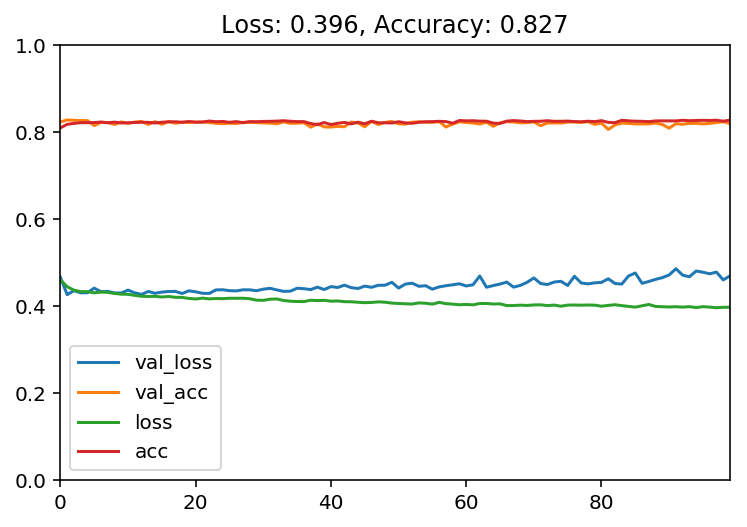

In [5]:
# Basic DNN model
model = Sequential()
model.add(Dense(12,input_shape=(80,), activation="relu"))
model.add(Dense(36, activation="relu"))
model.add(Dense(36, activation="relu"))
model.add(Dense(24, activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.compile(optimizer=Adam(lr=0.01),loss='binary_crossentropy',metrics=['accuracy'])
ann = model.fit(x=X_train,y=y_train,verbose=0,epochs=100, validation_split=0.3)
plot_loss_accuracy(ann)

In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                972       
_________________________________________________________________
dense_2 (Dense)              (None, 36)                468       
_________________________________________________________________
dense_3 (Dense)              (None, 36)                1332      
_________________________________________________________________
dense_4 (Dense)              (None, 24)                888       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 3,685
Trainable params: 3,685
Non-trainable params: 0
_________________________________________________________________


<Figure size 576x432 with 0 Axes>

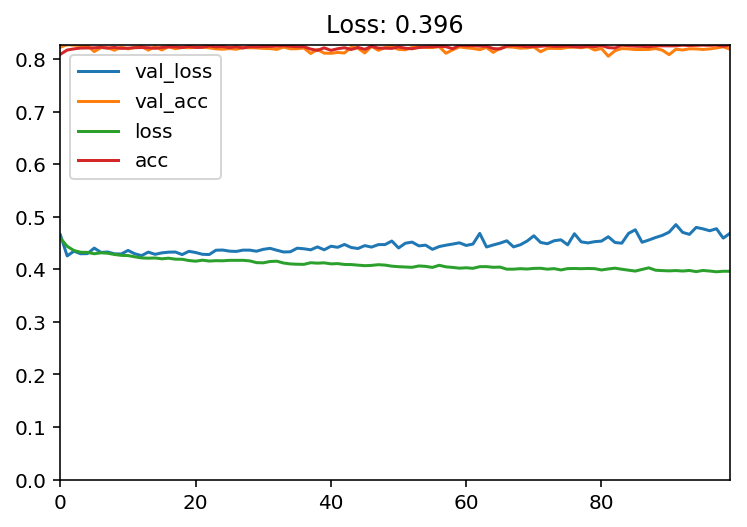

In [7]:
plot_loss(ann)

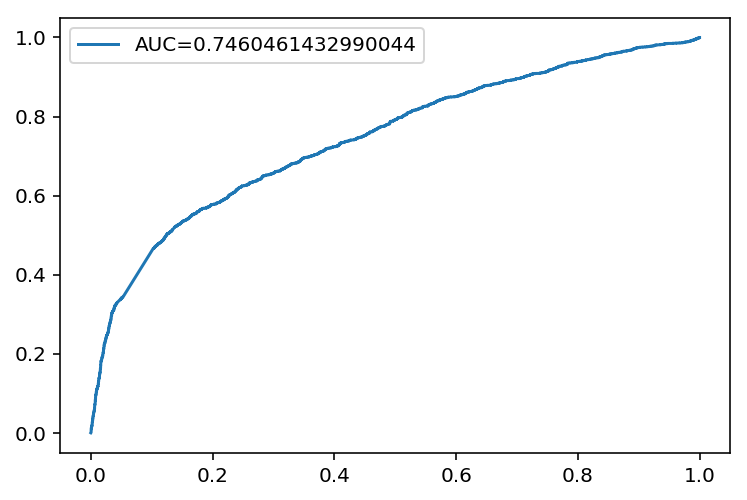

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      7009
           1       0.70      0.32      0.44      1991

   micro avg       0.82      0.82      0.82      9000
   macro avg       0.77      0.64      0.67      9000
weighted avg       0.80      0.82      0.79      9000

[[6731  278]
 [1350  641]]


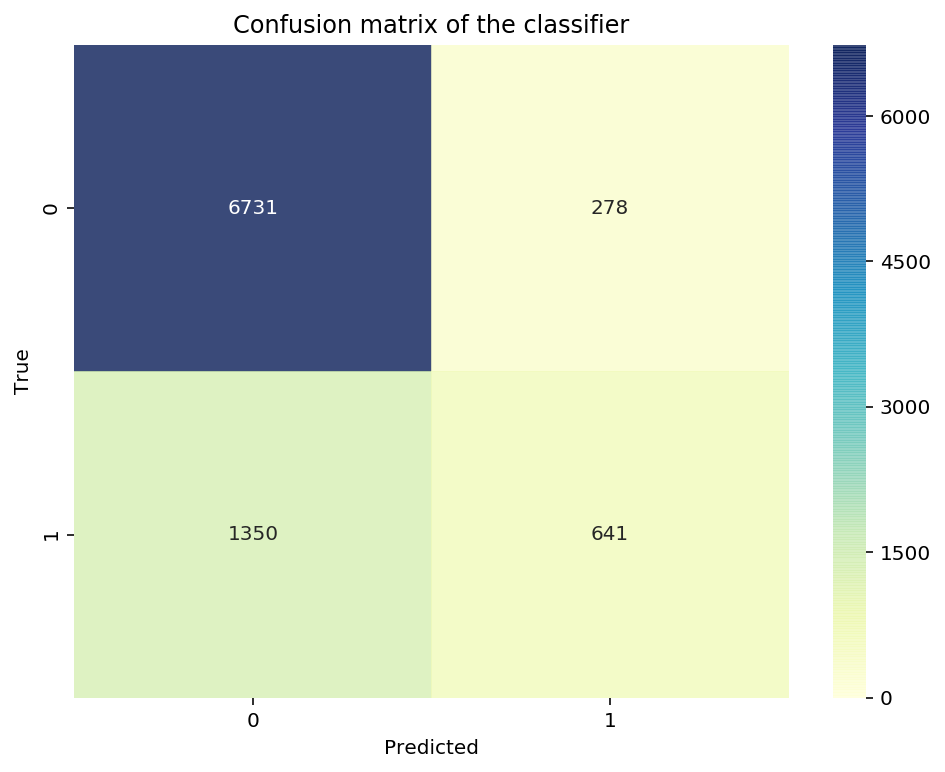

In [8]:
from sklearn import metrics

#AUC curve
y_pred_proba = model.predict(X_test).ravel()
fpr, tpr, t = metrics.roc_curve(y_test,  y_pred_proba) # 
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend()
plt.show()

# Get classification report
from sklearn.metrics import classification_report
y_pred_ann = model.predict_classes(X_test)
print(classification_report(y_test, y_pred_ann))

print(confusion_matrix(y_test,y_pred_ann))
plot_confusion_matrix(model,X_test,y_test)

Epoch 00012: early stopping


<Figure size 576x432 with 0 Axes>

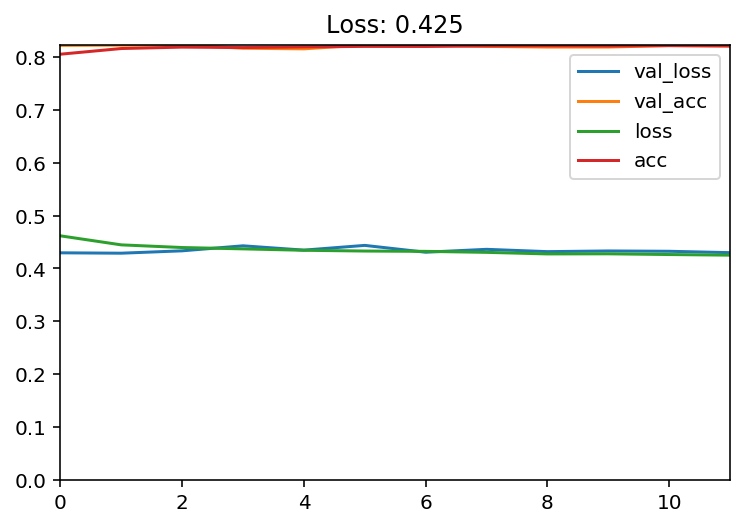

In [9]:
# Addressing overfitting
# Early stopping

model = Sequential()
model.add(Dense(12,input_shape=(80,), activation="relu"))
model.add(Dense(36, activation="relu"))
model.add(Dense(36, activation="relu"))
model.add(Dense(24, activation="relu"))
model.add(Dense(1,activation="sigmoid"))

early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model.compile(optimizer=Adam(lr=0.01),loss='binary_crossentropy',metrics=['accuracy'])
ann = model.fit(x=X_train,y=y_train,verbose=0,epochs=100,callbacks=[early_stop], validation_split=0.3)
plot_loss(ann)


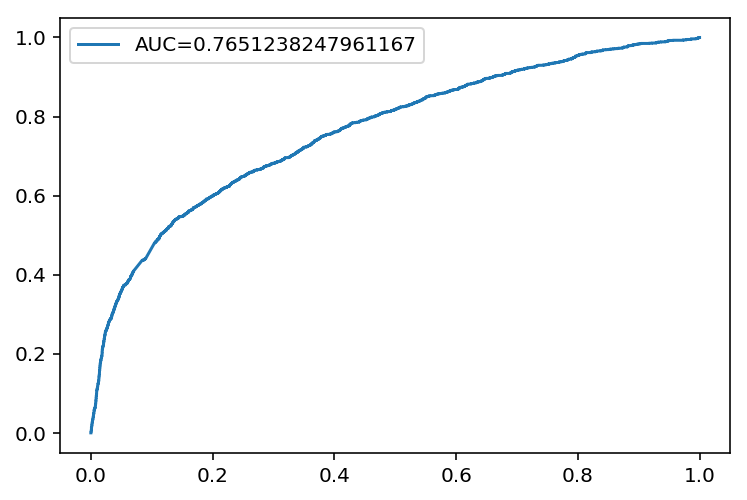

              precision    recall  f1-score   support

           0       0.83      0.96      0.89      7009
           1       0.70      0.30      0.42      1991

   micro avg       0.82      0.82      0.82      9000
   macro avg       0.77      0.63      0.66      9000
weighted avg       0.80      0.82      0.79      9000

[[6752  257]
 [1385  606]]


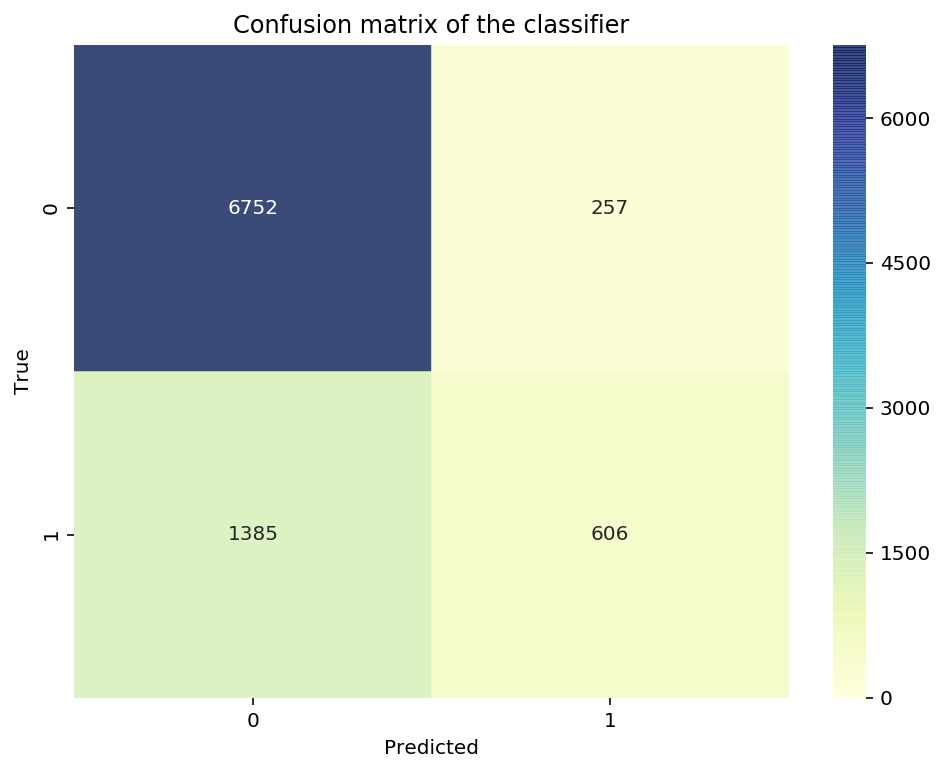

In [10]:
from sklearn import metrics

#AUC curve
y_pred_proba = model.predict(X_test).ravel()
fpr, tpr, t = metrics.roc_curve(y_test,  y_pred_proba) # 
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend()
plt.show()

# Get classification report
from sklearn.metrics import classification_report
y_pred_ann = model.predict_classes(X_test)
print(classification_report(y_test, y_pred_ann))

print(confusion_matrix(y_test,y_pred_ann))
plot_confusion_matrix(model,X_test,y_test)

Epoch 00021: early stopping


<Figure size 576x432 with 0 Axes>

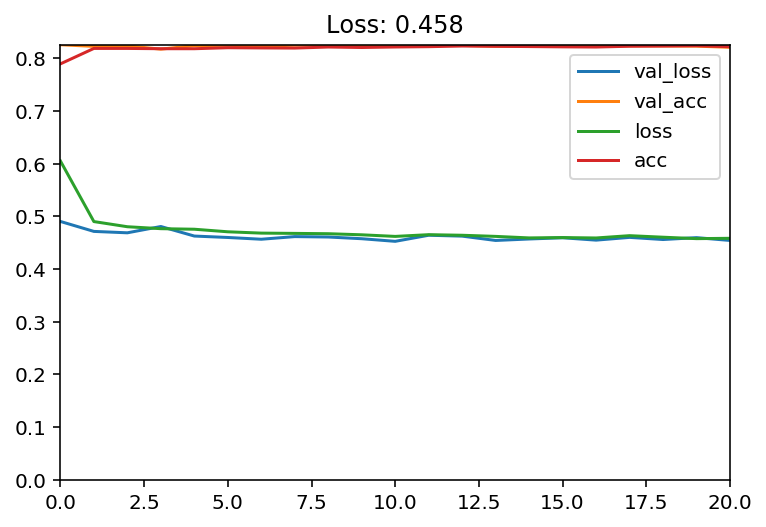

In [11]:
# Addressing overfitting
# Regularization
from keras import regularizers
model = Sequential()
model.add(Dense(12,input_shape=(80,), activation="relu"))
model.add(Dense(36, activation="relu",kernel_regularizer=regularizers.l1(0.01)))
model.add(Dense(36, activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(24, activation="relu",kernel_regularizer=regularizers.l1(0.01)))
model.add(Dense(1,activation="sigmoid"))

early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model.compile(optimizer=Adam(lr=0.01),loss='binary_crossentropy',metrics=['accuracy'])
ann = model.fit(x=X_train,y=y_train,verbose=0,epochs=100,callbacks=[early_stop], validation_split=0.3)
plot_loss(ann)

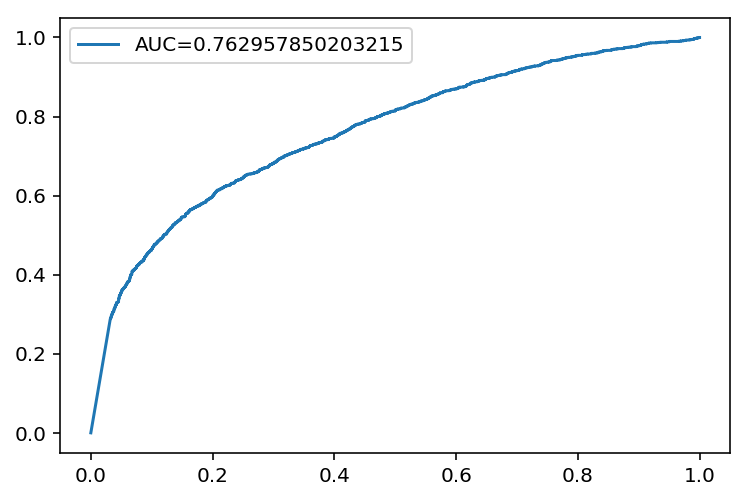

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      7009
           1       0.65      0.37      0.47      1991

   micro avg       0.82      0.82      0.82      9000
   macro avg       0.74      0.66      0.68      9000
weighted avg       0.80      0.82      0.80      9000

[[6602  407]
 [1245  746]]


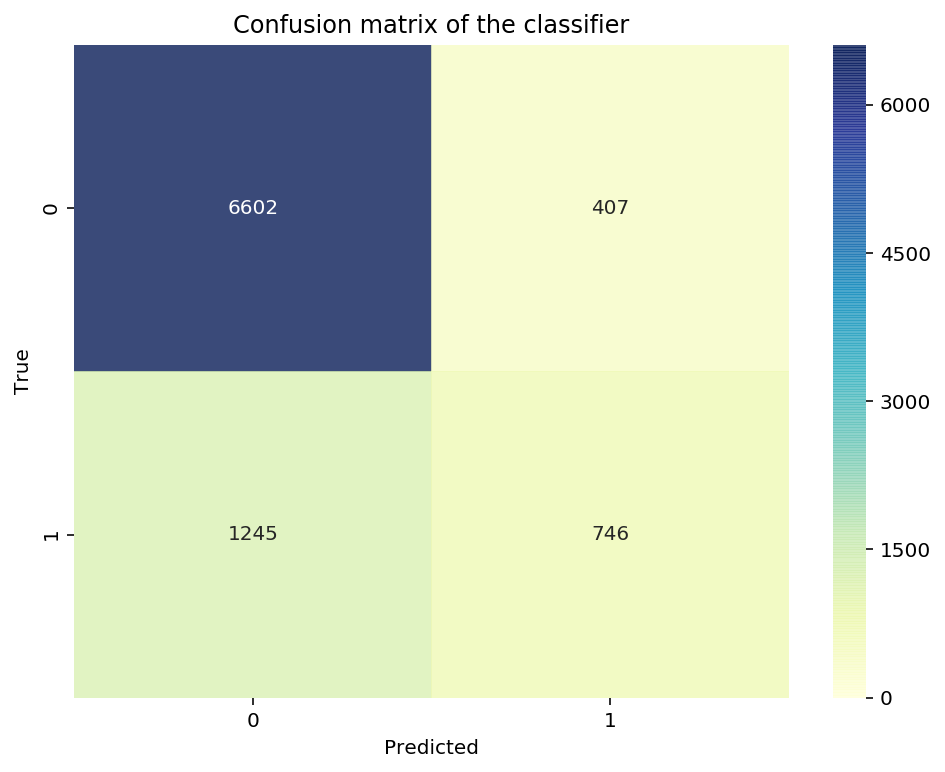

In [12]:
from sklearn import metrics

#AUC curve
y_pred_proba = model.predict(X_test).ravel()
fpr, tpr, t = metrics.roc_curve(y_test,  y_pred_proba) # 
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend()
plt.show()

# Get classification report
from sklearn.metrics import classification_report
y_pred_ann = model.predict_classes(X_test)
print(classification_report(y_test, y_pred_ann))

print(confusion_matrix(y_test,y_pred_ann))
plot_confusion_matrix(model,X_test,y_test)

Epoch 00032: early stopping


<Figure size 576x432 with 0 Axes>

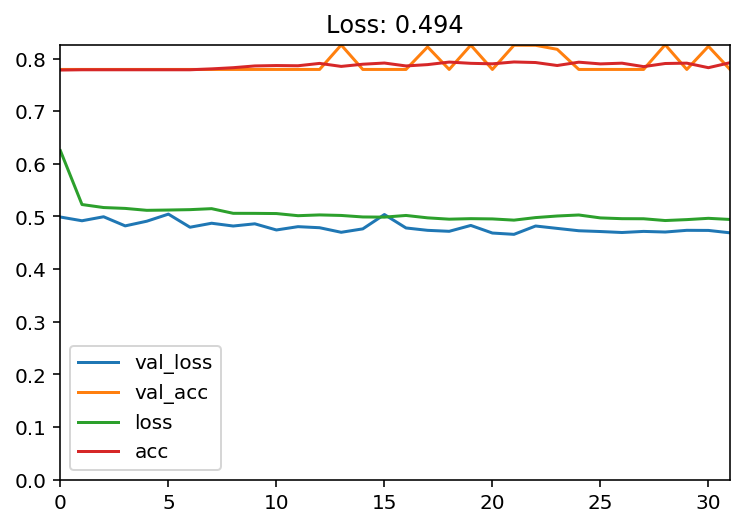

In [13]:
# Addressing overfitting
# Dropout

model = Sequential()
model.add(Dense(12,input_shape=(80,), activation="relu"))
model.add(Dropout(0.1))
model.add(Dense(36, activation="relu",kernel_regularizer=regularizers.l1(0.01)))
model.add(Dropout(0.1))
model.add(Dense(36, activation="relu",kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(24, activation="relu",kernel_regularizer=regularizers.l1(0.01)))
model.add(Dense(1,activation="sigmoid"))

early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

model.compile(optimizer=Adam(lr=0.01),loss='binary_crossentropy',metrics=['accuracy'])
ann = model.fit(x=X_train,y=y_train,verbose=0,epochs=100,callbacks=[early_stop], validation_split=0.3)
plot_loss(ann)

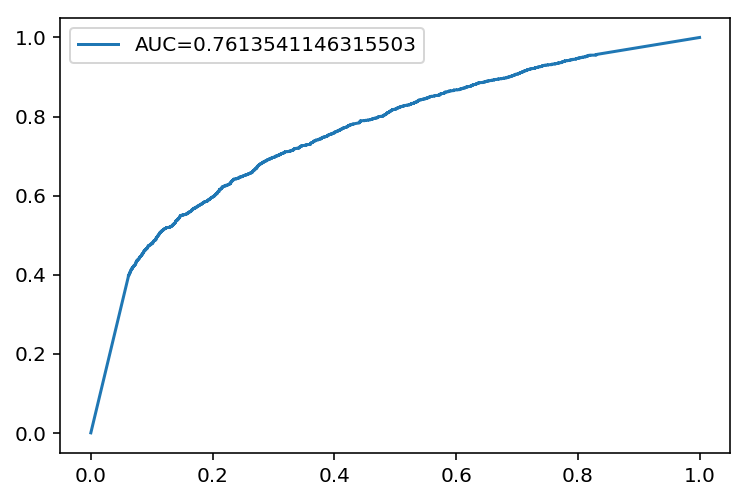

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      7009
           1       0.00      0.00      0.00      1991

   micro avg       0.78      0.78      0.78      9000
   macro avg       0.39      0.50      0.44      9000
weighted avg       0.61      0.78      0.68      9000

[[7009    0]
 [1991    0]]


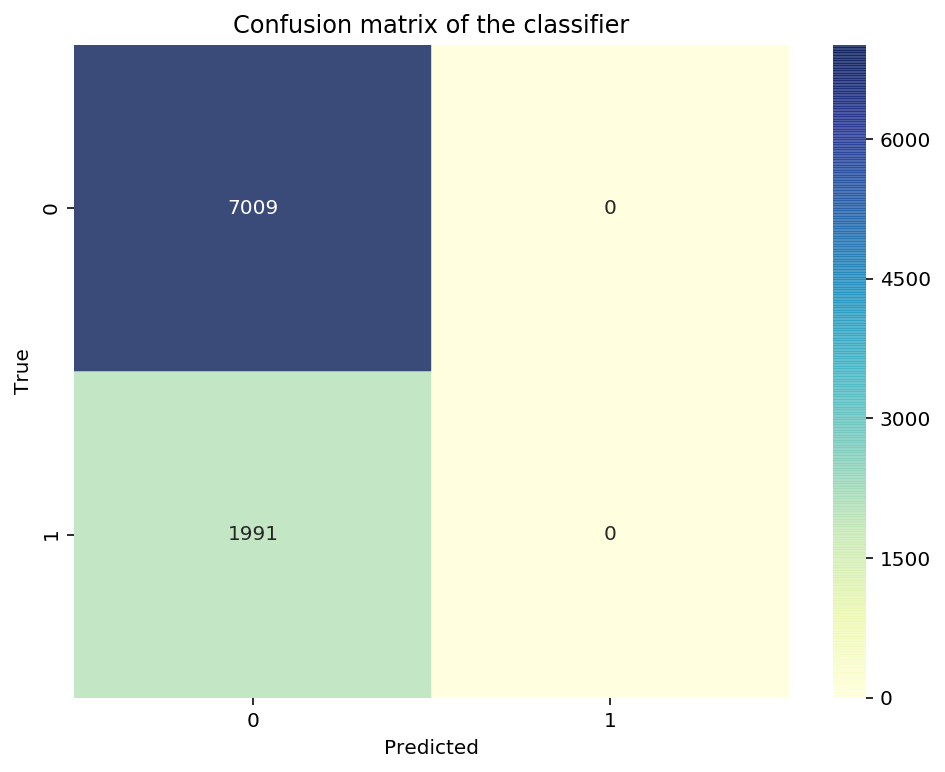

In [14]:
#AUC curve
y_pred_proba = model.predict(X_test).ravel()
fpr, tpr, t = metrics.roc_curve(y_test,  y_pred_proba) # 
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.legend()
plt.show()

# Get classification report
from sklearn.metrics import classification_report
y_pred_ann = model.predict_classes(X_test)
print(classification_report(y_test, y_pred_ann))

print(confusion_matrix(y_test,y_pred_ann))
plot_confusion_matrix(model,X_test,y_test)

In [15]:
# Hyperparameter tuning
!pip install talos

In [16]:
from keras.activations import relu, elu

p = {'activation1':[relu, elu],
     #'activation2':[relu, elu],
     'optimizer': ['Adam', "RMSprop"],
     #'losses': ['logcosh', keras.losses.binary_crossentropy],
     'first_hidden_layer': [10, 8, 6],
     #'batch_size': [100, 1000, 10000],
     'epochs': [10, 30]
    }

In [11]:
import talos
from keras import regularizers


def cred_model(x_train,y_train,x_val, y_val, params):
    model = Sequential()
    model.add(Dense(params['first_hidden_layer'],input_shape=(80,), activation=params['activation1']))
    model.add(Dropout(0.1))
    model.add(Dense(36, activation="relu",kernel_regularizer=regularizers.l1(0.01)))
    model.add(Dropout(0.1))
    model.add(Dense(36, activation="relu",kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(24, activation="relu",kernel_regularizer=regularizers.l1(0.01)))
    model.add(Dense(1,activation="sigmoid"))
    model.compile(optimizer=Adam(lr=0.01),loss='binary_crossentropy',metrics=['accuracy'])
    ann = model.fit(x=x_train,y=y_train,verbose=0,epochs=params['epochs'],callbacks=[talos.utils.early_stopper(epochs=params['epochs'], mode='moderate', monitor='val_loss')], validation_data=[x_val, y_val])
    return ann, model



In [12]:
from talos import Scan

h = Scan(x=X_train.values, y= y_train.values, model=cred_model, params=p, fraction_limit=0.1,experiment_name='1')


100%|████████████████████████████████████████████| 2/2 [00:10<00:00,  5.31s/it]


In [111]:
h.data

,round_epochs,val_loss,val_acc,loss,acc,activation1,epochs,first_hidden_layer
0,7,0.48,0.82,0.48,0.81,<function elu at 0x000000000EFE3EA0>,30,6


In [15]:
h.details

experiment_name                       1
random_method          uniform_mersenne
reduction_method                   None
reduction_interval                   50
reduction_window                     20
reduction_threshold                0.20
reduction_metric                val_acc
complete_time            10/31/19/22:59
x_shape                     (21000, 80)
y_shape                      (21000, 1)
dtype: object

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# Function to create model, required for KerasClassifier
def create_model(first_hidden_layer,activation1):
    model = Sequential()
    model.add(Dense(first_hidden_layer,input_shape=(80,), activation= activation1))
    model.add(Dropout(0.1))
    model.add(Dense(36, activation="relu",kernel_regularizer=regularizers.l1(0.01)))
    model.add(Dropout(0.1))
    model.add(Dense(36, activation="relu",kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(24, activation="relu",kernel_regularizer=regularizers.l1(0.01)))
    model.add(Dense(1,activation="sigmoid"))
    model.compile(optimizer=Adam(lr=0.01),loss='binary_crossentropy',metrics=['accuracy'])
    #ann = model.fit(x=x_train,y=y_train,verbose=0,epochs=params['epochs'],callbacks=[talos.utils.early_stopper(epochs=params['epochs'], mode='moderate', monitor='val_loss')], validation_data=[x_val, y_val])
    return model

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, epochs=100, batch_size=10, verbose=0)

#Define hyperparameter dict
p = {'activation1':[relu, elu],
     #'activation2':[relu, elu],
     #'optimizer': ['Adam', "RMSprop"],
     #'losses': ['logcosh', keras.losses.binary_crossentropy],
     'first_hidden_layer': [10, 8, 6],
     #'batch_size': [100, 1000, 10000],
     #'epochs': [10, 30]
    }

grid = RandomizedSearchCV(estimator=model, param_distributions=p, n_iter = 20, n_jobs = 4, cv = 3, random_state=111)
grid_result = grid.fit(X_train, y_train)